In [3]:
import requests, json, logging
from pathlib import Path

import pandas as pd
import numpy as np

In [75]:
def load_data() -> pd.DataFrame:
    """Loads data from data nsw and in future, other data sources"""
    
    def get_data_nsw(resource_id: str) -> pd.DataFrame:
        """Retrieve json data object and convert to pandas dataframe"""
    
        # Query API
        url = f'https://data.nsw.gov.au/data/api/3/action/datastore_search?resource_id={resource_id}&limit=100000'  
        res = requests.get(url)
        records = res.json()['result']['records']

        # Convert to dataframe
        df = pd.DataFrame(records)

        # Get daily values
        df = pd.to_datetime(df.iloc[:,0]).dt.floor('d').value_counts().rename_axis('date').reset_index(name='count')
        
        return df
    
    # resource IDS for data nsw APIs 
    resource_ids = {
        'testing': '945c6204-272a-4cad-8e33-dde791f5059a',
        'cases': '21304414-1ff1-4243-a5d2-f52778048b29'
    }
    
    cases_df = get_data_nsw(resource_ids['cases'])
    tests_df = get_data_nsw(resource_ids['testing'])
    
    df = pd.merge(cases_df, tests_df, how='inner')
    # Load Google Trends
    df["lockdown_trend"] = None
    # Load Twitter?
    
    df["news"] = None
    
    # Save to csv
    df.to_csv("data/raw_data.csv")
    return df

df = load_data()

In [76]:
# df.set_index('date', inplace=True)
df.head()

,date,count,lockdown_trend,news


In [53]:
import matplotlib.pyplot as plt

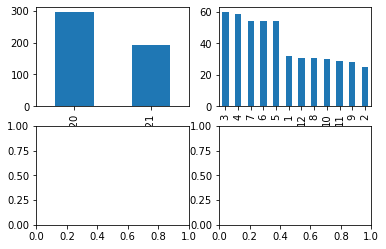

In [62]:
fig, axes = plt.subplots(nrows=2, ncols=2)
df.index.year.value_counts().plot.bar(ax=axes[0,0])
df.index.month.value_counts().plot.bar(ax=axes[0,1])

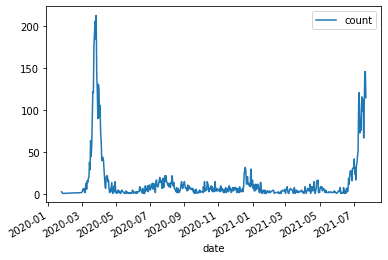

In [64]:
df.plot()

In [ ]:
def print_ts(df: pd.DataFrame) -> None:
    pass

